In [1]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as geopd
from shapely.geometry import Point

import hdbscan
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

Создаем объект DataFrame из файла статистики абонента

In [2]:
ab_stat = pd.read_excel('ab_stat.xlsx', index_col=False)
ab_stat.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22149 entries, 0 to 22148
Data columns (total 21 columns):
Unnamed: 0    22149 non-null int64
DATE          22149 non-null datetime64[ns]
DURATION      22149 non-null float64
TYPE          22149 non-null object
DIRECTION     22149 non-null object
MSISDN_A      22149 non-null int64
IMSI_A        22149 non-null int64
IMEI_A        21095 non-null float64
MSISDN_B      2670 non-null float64
LAC_A         22149 non-null int64
CELLID_A      22149 non-null int64
AZIMUTH_A     22149 non-null int64
ADDRESS_A     22073 non-null object
ROAMING       22149 non-null object
LAC           22149 non-null int64
CELL          22149 non-null int64
ADDRESS       22149 non-null object
LON           22149 non-null float64
LAT           22149 non-null float64
AZIMUTH       21862 non-null float64
LOCATION      20644 non-null object
dtypes: datetime64[ns](1), float64(6), int64(8), object(6)
memory usage: 3.5+ MB


Коодрдинту БС относим на 300 метров от расположения БС по направлению AZIMUTH  
для расположения outdoor 

In [3]:
#ab_stat['']

In [4]:
lat_long = ab_stat[['LAT', 'LON', 'AZIMUTH', 'LOCATION']]

In [5]:
lat_long_uniq = lat_long.drop_duplicates()
geodf = geopd.GeoDataFrame(lat_long_uniq, geometry=geopd.points_from_xy(lat_long_uniq.LAT, lat_long_uniq.LON))
geodf.head()

,LAT,LON,AZIMUTH,LOCATION,geometry
0,56.284410,38.396787,200.0,outdoor,POINT (56.28441 38.39679)
111,56.288675,38.210756,60.0,outdoor,POINT (56.28867 38.21076)
115,55.715389,37.665209,310.0,outdoor,POINT (55.71539 37.66521)
289,55.746933,37.707497,0.0,indoor,POINT (55.74693 37.70750)
297,55.748059,37.706855,0.0,indoor,POINT (55.74806 37.70685)


In [6]:
def my_translate(g):
    if g.LOCATION == 'outdoor':
        gr_meter = 111120 # метров в 1 градусе широты
        dist = 300 # сдвиг в метрах
        dist_gr_lat = dist / gr_meter # сдвиг по широте в градусах
        dist_gr_lon = dist_gr_lat * np.cos(g.geometry.x) # сдвиг по долготе в градусах
        
        g.geometry = Point(g.geometry.x + np.cos(np.deg2rad(g.AZIMUTH)) * dist_gr_lat,
                  g.geometry.y + np.sin(np.deg2rad(g.AZIMUTH)) * dist_gr_lon)
    return g

 
geodf_300 = geodf.apply(my_translate, axis=1)

geodf_300.LAT = geodf_300.geometry.x
geodf_300.LON = geodf_300.geometry.y

geodf_300.head()

,LAT,LON,AZIMUTH,LOCATION,geometry
0,56.281873,38.395896,200.0,outdoor,POINT (56.28187 38.39590)
111,56.290025,38.213016,60.0,outdoor,POINT (56.29002 38.21302)
115,55.717124,37.663818,310.0,outdoor,POINT (55.71712 37.66382)
289,55.746933,37.707497,0.0,indoor,POINT (55.74693 37.70750)
297,55.748059,37.706855,0.0,indoor,POINT (55.74806 37.70685)


In [7]:
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0, }

In [8]:
rad_uniq = np.deg2rad(geodf_300[['LAT', 'LON']])
rad_uniq.head()

,LAT,LON
0,0.982304,0.670135
111,0.982446,0.666943
115,0.972447,0.657358
289,0.972968,0.658120
297,0.972987,0.658109


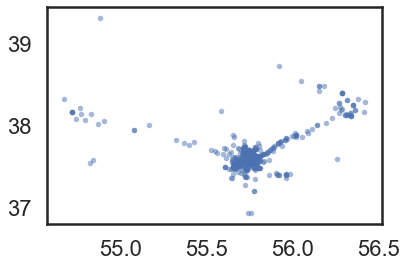

In [9]:
plt.scatter(lat_long_uniq.LAT, lat_long_uniq.LON, color='b', **plot_kwds)

In [10]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric='haversine')
clusterer.fit(rad_uniq)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='haversine', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [11]:
clusterer.labels_, clusterer.probabilities_

(array([ 1,  1, -1, 15, 15,  0, -1, 30, 30, 30, 30, 26, 26, 30, -1, -1, 30,
        -1, -1,  1,  4,  4,  4, 30, 26, 15, 15, 25, 20, -1, -1, -1, -1, -1,
        20, -1, -1, -1, 20, 21, 20, -1, 30, 30, 30, 30, -1, 18, 18,  5,  5,
         5, 10, 26, -1, 17, 17, 19, 19, -1, 21, 21, 30, 30, 15, 29, 29, 26,
        26, -1, 23,  0,  0,  0, 29, -1, 24, 24, -1, -1, -1, 15, -1, 30, 30,
        14, 14, 14, 14, -1, 30, -1, -1, 21, 30, 30,  9, 30, -1, 20, 13,  6,
        -1, -1, 21, 27, 29, -1, -1, 21, 21, -1,  2,  2, 27, -1, 23, -1, -1,
        30, -1, -1, -1, -1, -1, -1, -1, 29, -1, 19, -1, -1, 13, 30, -1, -1,
        -1, -1, 17, 30, 30, 30, 30, 30, 20, 30, 30, 30, 30, 30, -1, -1, 30,
        21, -1, -1,  0,  0,  0, -1, 30, 22, 23, -1, 30, 30, 12, 12, -1,  7,
         1, 30, 30, 29, 21, 24, 30, -1, 29, 29, 22, 30, 30, 13, 13, -1,  4,
        -1, 30, 30, 30, -1, -1, 30, -1, 24, 27, 13, 23, 23,  5, 23, -1,  4,
         1,  1,  7, -1, -1, -1, -1, -1, -1, -1,  0,  0, 30, 22, 26, 30, 30,
        -1, 

In [12]:
len(set(clusterer.labels_))

32

In [13]:
geodf_300['cluster'] = clusterer.labels_
geodf_300['probabilities'] = clusterer.probabilities_
geodf_300.head()

,LAT,LON,AZIMUTH,LOCATION,geometry,cluster,probabilities
0,56.281873,38.395896,200.0,outdoor,POINT (56.28187 38.39590),1,0.207513
111,56.290025,38.213016,60.0,outdoor,POINT (56.29002 38.21302),1,0.278360
115,55.717124,37.663818,310.0,outdoor,POINT (55.71712 37.66382),-1,0.000000
289,55.746933,37.707497,0.0,indoor,POINT (55.74693 37.70750),15,1.000000
297,55.748059,37.706855,0.0,indoor,POINT (55.74806 37.70685),15,1.000000


In [17]:
mx = 10
geodf_300_plot = geodf_300.loc[(geodf_300.cluster > 0) & (geodf_300.cluster < mx)]

In [18]:
palette = sns.color_palette()


cluster_colors = [sns.desaturate(palette[row['cluster']-mx], row['probabilities'])
                  if row['cluster'] >= 0 else (0.5, 0.5, 0.5) for row in
                  geodf_300_plot[['cluster', 'probabilities']].to_dict('records')]


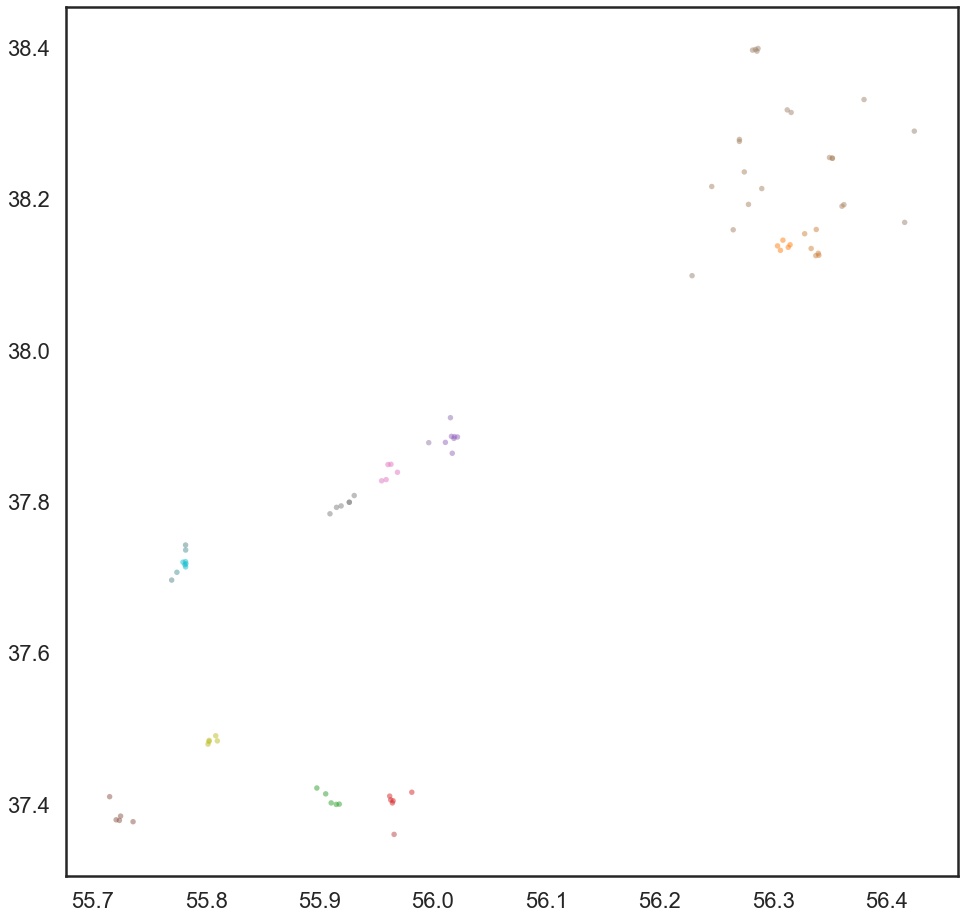

In [19]:
plt.figure(figsize=(16, 16))
plt.scatter(geodf_300_plot['LAT'], geodf_300_plot['LON'], c=cluster_colors, **plot_kwds)
